# 系统性金融风险监测
## 项目目标
- 通过对市场数据的分析，监测系统性金融风险的变化情况
## 项目流程
### 1. 包的导入

In [ ]:
from numpy import dot,diag,power,multiply,log
from pandas import concat,to_datetime
from algorithm import pca, combine, risk_possibility, markov_analysis
from preprocessing import clean, get_arch, unify_unity, save_output
from draw_img import single_line,double_line
from warnings import filterwarnings

### 2. 数据准备
市场集合

In [ ]:
markets = ["股票市场","债券市场","外汇市场","货币市场","衍生品市场"]

目标指标名

In [ ]:
goal = "系统性金融风险"

每个子市场的权重

In [ ]:
weights = [0.3,0.3,0.1,0.2,0.1]

经过PCA分析后在各市场中选出的指标集合

In [ ]:
chosen_indexes = [["市盈率Q","换手率R","融券融资比S","涨跌幅绝对波动U"],# 股票市场
                ["国债期限溢价","综合风险溢价","中证综合债指数波动率(%)"],# 债券市场
                ["人民币汇率市场扭曲程度","美元兑人民币中间价USD/CNY波动率(%)"],# 外汇市场
                ["流动性溢价","银行间质押式回购加权利率:1天（一阶差分）波动率",
                 "银行间质押式回购加权利率:7天（一阶差分）波动率","SHIBOR:3个月（一阶差分）波动率"],# 货币市场
                  ["股值期货价格偏离度","沪深300指数期货日对数收益率波动率(%)"]]# 衍生品市场

每个市场中待分析的指标总数量

In [ ]:
index_nums = [7,3,2,4,2]

图片格式

In [ ]:
img_format = "svg"

区制名称

In [ ]:
regime = ["中低风险","高风险"]

各市场指数结果

In [ ]:
market_indexes = []

### 3. 数据处理
#### 3.1 计算各市场指数

In [ ]:
for market, index_num, chosen_index in zip(markets,index_nums,chosen_indexes):
    # 数据预处理
    # clean(market)
    # 读取数据并标准化
    order_norm_data, stats = unify_unity(market, index_num)
    # PCA分析子市场中各三级指标
    pca(market, index_num, order_norm_data)
    # 加权合成子市场指数
    market_index = combine(market, order_norm_data, chosen_index, stats)
    # 绘制子市场指数
    single_line(market+"压力指数",market, market_index.index, market_index.loc[:,market])
    # 将子市场指数添加到列表中
    market_indexes.append(market_index)

#### 3.2 计算合成指数

将列表中的子市场指数合并到一个DataFrame中

In [ ]:
data_frame = concat(market_indexes, axis=1)

删除空值

In [ ]:
data_frame.dropna(axis=0, how='any', inplace=True)

In [ ]:
# 将索引转换为时间戳
# data_frame.index = DatetimeIndex(data_frame.index).to_period('D')

计算相关系数矩阵

In [ ]:
corr = data_frame.corr()

合成系统性金融风险压力指数
\begin{equation*}
vec = W \cdot P_t = \begin{bmatrix} W_1,W_2,W_3,W_4,W_5\end{bmatrix} \cdot

\end{equation*}

\begin{bmatrix}
    \begin{matrix}
        1&\rho_{12,t}&\rho_{13,t}&\rho_{14,t}&\rho_{15,t}\\
        \rho_{21,t}&1&\rho_{23,t}&\rho_{24,t}&\rho_{25,t}\\
        \rho_{31,t}&\rho_{32,t}&1&\rho_{34,t}&\rho_{35,t}\\
        \rho_{41,t}&\rho_{42,t}&\rho_{43,t}&1&\rho_{45,t}\\
        \rho_{51,t}&\rho_{52,t}&\rho_{53,t}&\rho_{54,t}&1\\
    \end{matrix}
\end{bmatrix}

\begin{equation*}
\text{系统性金融风险指数} = \sqrt{vec \cdot P_t \cdot vec^T} \times 2
\end{equation*}

In [ ]:
vec = dot(data_frame.values, diag(weights))
data_frame.loc[:,goal] = power(multiply(dot(vec, corr), vec).sum(axis=1), 0.5)*2
data_frame.sort_index(inplace=True, ascending=False)

保存合成指数

In [ ]:
data_frame.index = to_datetime(data_frame.index, format='%Y/%m/%d').date
data_frame.index.name = "日期"
save_output( goal, data_frame, "指数汇总")
# 绘制合成指数
single_line(goal+"压力指数",goal, data_frame.index, data_frame.loc[:,goal].values)

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                 3223
Model:               MarkovRegression   Log Likelihood                1323.557
Date:                Thu, 06 Mar 2025   AIC                          -2635.113
Time:                        00:57:37   BIC                          -2598.645
Sample:                             0   HQIC                         -2622.043
                               - 3223                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2587      0.001   -189.669      0.000      -0.261      -0.256
sigma2      3.695e-06   3.71e-06      0.995      0.3

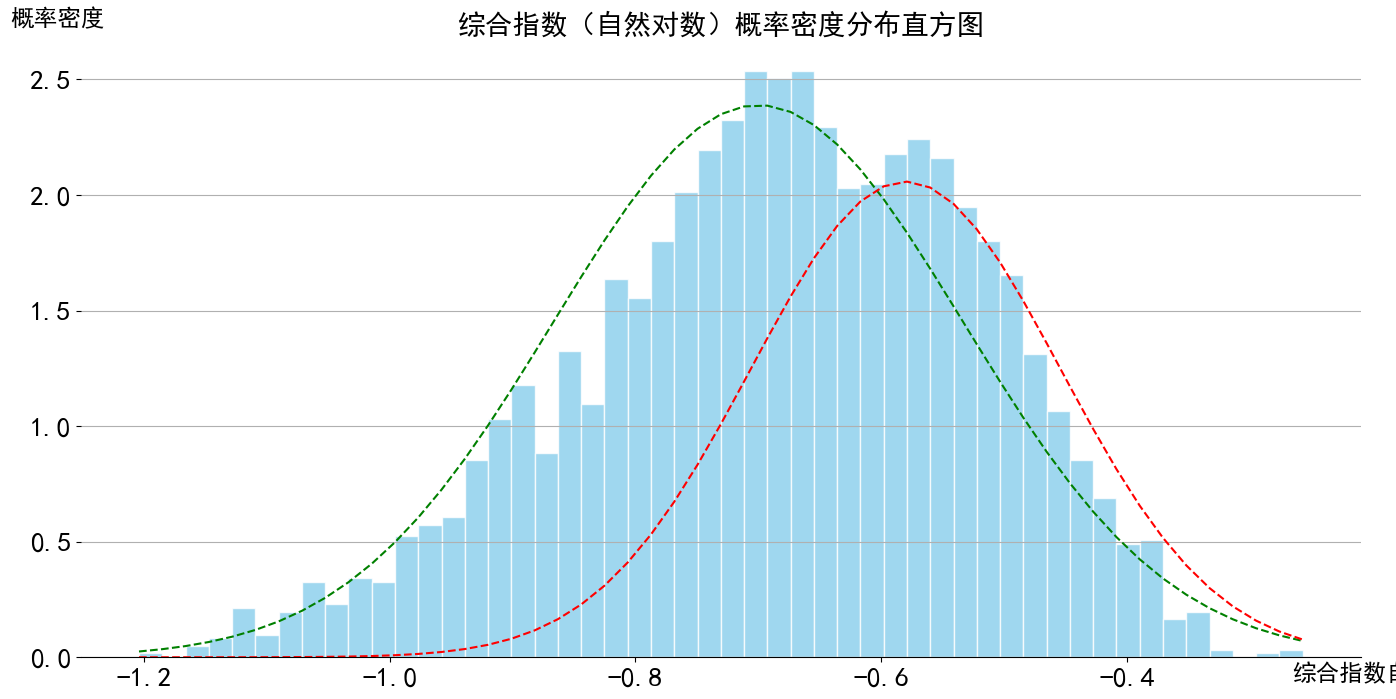

In [3]:
import pandas as pd
from algorithm import markov_analysis,risk_possibility
from numpy import log
data_frame = pd.read_excel("Database3.xlsx",index_col=0)
goal="综合指数"
# 马尔科夫区制转换分析
markov_analysis(log(data_frame.loc[:,goal].values.astype(float)))
# 风险概率分析
regime = ["中低风险","高风险"]
possibility = risk_possibility(goal, data_frame, regime)
possibility[goal] = data_frame.loc[:,goal].values
possibility.to_excel("输出.xlsx")
# save_output("导出数据",possibility)
# double_line("风险区制概率密度情况",regime, data_frame.index, possibility)
